# Modelling detection.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from files import loaddata, dump_pkl, load_pkl

## Reading Data.

The raw matlab data has been converted to numpy zipped format and stored in the `data` directory. These data files have had their phase equalized. 

File naming convention is `<subj>_<contrast>_<mode>.pkl` where `<subj>` is `cm`, `cs`, or `whm`, and `<contrast>` is 0, 25, 50 or 75, and `<mode>` is `5noise` or `thresh`

In [2]:
# load some phase-standardized data & display characteristics
data = loaddata('whm',0,'5noise')
print(list(data.keys()))
print('pedestal', data['pedestal'].shape)
print('pedestal_test', data['pedestal_test'].shape)
print('correct', data['correct'].shape)
print('phase', data['phase'].shape)
print('target', data['target'].shape) # target is normalized, but in experiments it has a peak of 1

['contrast', 'correct', 'phase', 'pedestal', 'pedestal_test', 'target']
pedestal (1800, 154)
pedestal_test (1800, 154)
correct (1800,)
phase (1800,)
target (154,)


In [3]:
import os
import sys
up = os.path.normpath(os.path.join(os.getcwd(), "../src"))
sys.path.append(up)
sys.path.append(os.getcwd())

In [4]:
from maxmf.glm import logisticGLM, Binomial
from maxmf.minimize import maximize

In [5]:
y = data['correct']
X = data['pedestal_test']-data['pedestal']

def smooth(b):
    return np.sum(np.diff(b, n=2, prepend=[0,0], append=[0,0])**2)

from time import perf_counter
t=perf_counter()
result = maximize(lambda b: logisticGLM(b, y, X)-150*smooth(b), np.zeros((154,)), report=1)
print('elapsed', perf_counter()-t)

Newton's method
Iteration    1 fval -1007.03 grad 6.027564e-01 : newton step
Iteration    2 fval -1000.68 grad 7.808861e-02 : newton step
Iteration    3 fval -1000.65 grad 5.455372e-03 : newton step
Iteration    4 fval -1000.65 grad 3.530168e-05 : newton step
Iteration    5 fval -1000.65 grad 1.569025e-09
Gradient convergence in iteration 5, final value -1000.6468285642766
elapsed 0.09098499999999987


In [6]:
import cProfile
#cProfile.run('maximize(lambda b: logisticGLM(b, y, X)-150*smooth(b), np.zeros((154,)), report=1)')

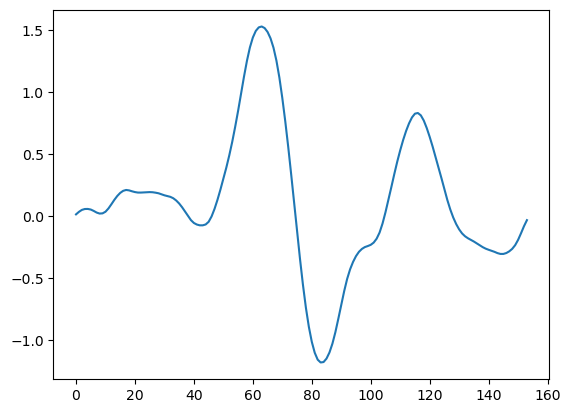

In [7]:
plt.plot(result['beta'])

In [8]:
def bothphase(b, X1, X2):
    nu1 = X1@b # response to target
    nu2 = X2@b # response to distractor
    #return 1/(1+np.exp(-np.abs(nu1-nu2)))
    p1 = np.exp(nu1)+np.exp(-nu1)
    p2 = np.exp(nu2)+np.exp(-nu2)
    return p1/(p1+p2)

binF = Binomial(bothphase)

t=perf_counter()
result2 = maximize(lambda b: binF(b, y, data['pedestal_test'], data['pedestal'])-150*smooth(b), 
                  np.random.rand(154), fconv=0e-5, maxiters=100, report=1)
print('elapsed', perf_counter()-t)

Newton's method
Iteration    1 fval -1226.15 grad 5.410447e+01 : newton step
Iteration    2 fval -984.934 grad 1.708440e-01 : newton step
Iteration    3 fval -972.609 grad 6.649296e-02 : newton step
Iteration    4 fval -972.056 grad 1.753055e-02 : newton step
Iteration    5 fval -972.036 grad 2.648460e-03 : newton step
Iteration    6 fval -972.035 grad 6.098860e-04 : newton step
Iteration    7 fval -972.035 grad 1.390746e-04 : newton step
Iteration    8 fval -972.035 grad 3.538052e-05 : newton step
Iteration    9 fval -972.035 grad 8.974675e-06 : newton step
Iteration   10 fval -972.035 grad 2.461920e-06 : newton step
Iteration   11 fval -972.035 grad 6.841844e-07 : newton step
Iteration   12 fval -972.035 grad 1.977093e-07 : newton step
Iteration   13 fval -972.035 grad 5.779488e-08 : newton step
Iteration   14 fval -972.035 grad 1.715180e-08 : newton step
Iteration   15 fval -972.035 grad 5.120003e-09
Gradient convergence in iteration 15, final value -972.0349679827902
elapsed 0.8885

In [9]:
#cProfile.run("maximize(lambda b: binF(b, y, data['pedestal_test'], data['pedestal'])-150*smooth(b), np.random.rand(154), fconv=0e-5, maxiters=100, report=1)")

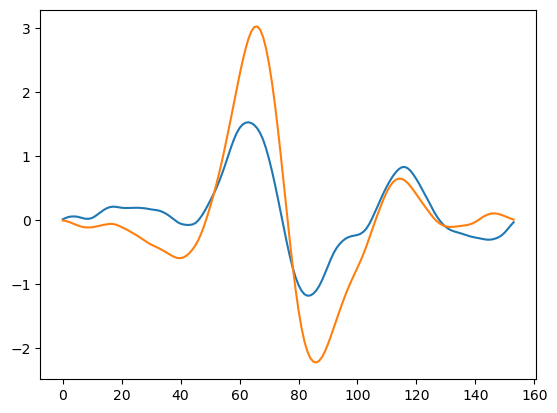

In [10]:
plt.plot(result['beta'])
s = np.sign(np.dot(result['beta'], result2['beta']))
plt.plot(s*result2['beta'])

In [13]:
from maxmf.autodiff.convolve import tensorcorrelate, tensorconvolve

In [22]:
sz = 80
conv1 = tensorconvolve(data['pedestal_test'], np.random.rand(sz), mode='valid', returntype='callable')
conv2 = tensorconvolve(data['pedestal'], np.random.rand(sz), mode='valid', returntype='callable')

def bothphase(b, X1, X2):
    nu1 = conv1(b) # response to target
    nu2 = conv2(b) # response to distractor
    p1 = np.sum(np.exp(nu1)+np.exp(-nu1), axis=1)
    p2 = np.sum(np.exp(nu2)+np.exp(-nu2), axis=1)
    return p1/(p1+p2)

binF2 = Binomial(bothphase)
#binF(np.random.rand(sz), y, data['pedestal_test'], data['pedestal'])

In [23]:
t=perf_counter()
result3 = maximize(lambda b: binF2(b, y, data['pedestal_test'], data['pedestal'])-100*smooth(b), 
                  np.random.rand(sz), fconv=1e-5, maxiters=100, report=1)
print('elapsed', perf_counter()-t)

Newton's method
Iteration    1 fval -1328.46 grad 5.324095e+01 : newton step
Iteration    2 fval -1001.83 grad 3.355237e-01 : shrunken newton step 0.5
Iteration    3 fval -982.561 grad 1.314393e-01 : newton step
Iteration    4 fval -981.821 grad 1.676342e-02 : newton step
Iteration    5 fval -981.578 grad 3.353293e-03 : newton step
Iteration    6 fval  -981.42 grad 2.637425e-03 : newton step
Iteration    7 fval -981.308 grad 2.141200e-03 : newton step
Iteration    8 fval -981.225 grad 1.751744e-03 : newton step
Iteration    9 fval -981.164 grad 1.442315e-03 : newton step
Iteration   10 fval -981.117 grad 1.197855e-03 : newton step
Iteration   11 fval  -981.08 grad 1.012186e-03 : newton step
Iteration   12 fval  -981.05 grad 8.772958e-04 : newton step
Iteration   13 fval -981.024 grad 7.836155e-04 : newton step
Iteration   14 fval     -981 grad 7.222220e-04 : newton step
Iteration   15 fval -980.977 grad 6.859407e-04 : newton step
Iteration   16 fval -980.954 grad 6.694400e-04 : newton 

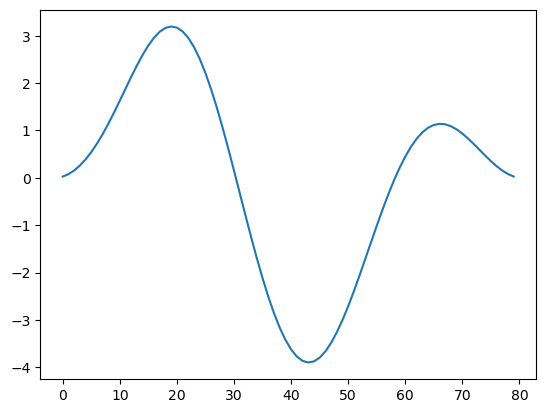

In [24]:
plt.plot(result3['beta'])